In [ ]:
!pip install kagglehub

In [ ]:
!pip install opencv-python

In [1]:

import os
import re
import cv2
import datetime
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import warnings



In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mbornoe/lisa-traffic-light-dataset")

print("Path to dataset files:", path)


Path to dataset files: C:\Users\leoja\.cache\kagglehub\datasets\mbornoe\lisa-traffic-light-dataset\versions\2


In [3]:
target_classes = ['go', 'stop', 'warning']
DAY_TRAIN_PATH = 'C:/Users/leoja/.cache/kagglehub/datasets/mbornoe/lisa-traffic-light-dataset/versions/2/Annotations/Annotations/dayTrain/'
train = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    # if 'dayClip' not in clipName:
    #     continue
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    df['Filename'] = df['Filename'].apply(lambda filename: re.findall("\/([\d\w-]*.jpg)", filename)[0])
    df['image_path'] = 'C:/Users/leoja/.cache/kagglehub/datasets/mbornoe/lisa-traffic-light-dataset/versions/2/dayTrain/dayTrain/' + clipName + '/frames/' + df['Filename']
    train.append(df)
    
df = pd.concat(train,axis=0)
df = df[df['Annotation tag'].isin(target_classes)]
df = df.drop(['Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number'], axis=1)
df.columns = ['filename', 'label', 'x1', 'y1', 'x2', 'y2', 'image_id']
df.label = pd.Categorical(df.label)
df = df.drop_duplicates().reset_index(drop=True)


  0%|          | 0/13 [00:00<?, ?it/s]

In [4]:
df

,filename,label,x1,y1,x2,y2,image_id
0,dayClip1--00000.jpg,go,698,333,710,358,C:/Users/leoja/.cache/kagglehub/datasets/mborn...
1,dayClip1--00000.jpg,go,846,391,858,411,C:/Users/leoja/.cache/kagglehub/datasets/mborn...
2,dayClip1--00001.jpg,go,698,337,710,357,C:/Users/leoja/.cache/kagglehub/datasets/mborn...
3,dayClip1--00001.jpg,go,847,390,859,410,C:/Users/leoja/.cache/kagglehub/datasets/mborn...
4,dayClip1--00002.jpg,go,698,331,710,356,C:/Users/leoja/.cache/kagglehub/datasets/mborn...
...,...,...,...,...,...,...,...
29693,dayClip9--00906.jpg,go,1139,157,1187,232,C:/Users/leoja/.cache/kagglehub/datasets/mborn...
29694,dayClip9--00907.jpg,go,1159,153,1204,233,C:/Users/leoja/.cache/kagglehub/datasets/mborn...
29695,dayClip9--00908.jpg,go,1185,150,1224,230,C:/Users/leoja/.cache/kagglehub/datasets/mborn...
29696,dayClip9--00909.jpg,go,1199,141,1256,226,C:/Users/leoja/.cache/kagglehub/datasets/mborn...


In [7]:
df['label'].value_counts()
# df['target'].value_counts(normalize=True)

label
stop       15113
go         13830
warning      755
Name: count, dtype: int64

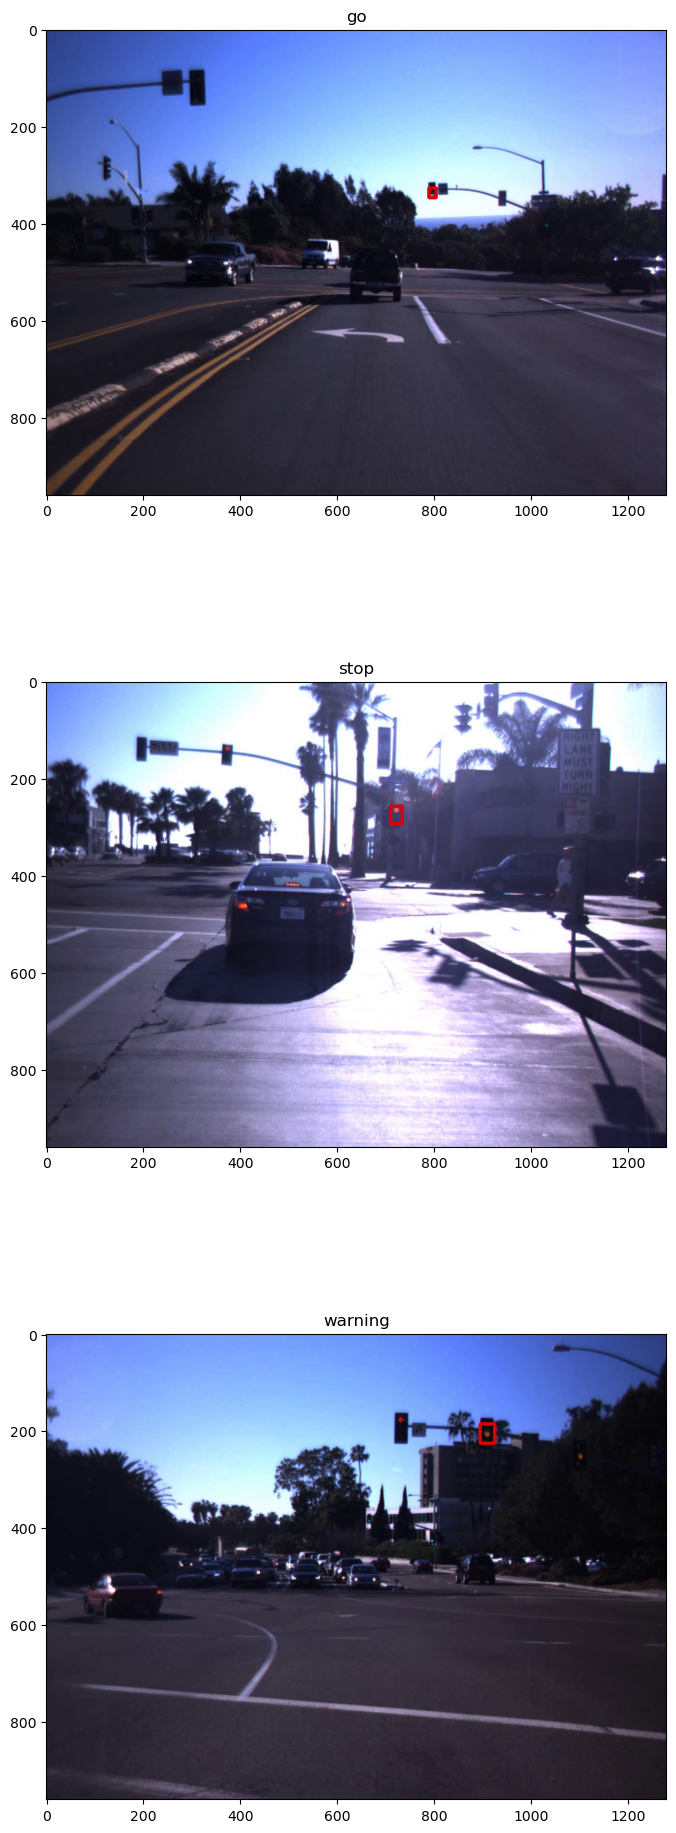

In [8]:
fig, ax = plt.subplots(len(target_classes),1,figsize=(8,8*len(target_classes)))
for i, tag in enumerate(target_classes):
    sample = df[df['label']==tag].sample(1,)
    bbox = sample[['x1','y1','x2','y2']].values[0]
    image = cv2.imread(sample.image_id.values[0])
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(220, 0, 0), 5)
    ax[i].set_title(tag)
    # ax[i].set_axis_off()
    ax[i].imshow(image)

### Preprocessing and splitting

In [9]:
# Create a new column for splitting
df['clipNames'] = df[['image_id']].applymap(lambda x: x.split('/')[12])

In [10]:
df

,filename,label,x1,y1,x2,y2,image_id,clipNames
0,dayClip1--00000.jpg,go,698,333,710,358,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip1
1,dayClip1--00000.jpg,go,846,391,858,411,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip1
2,dayClip1--00001.jpg,go,698,337,710,357,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip1
3,dayClip1--00001.jpg,go,847,390,859,410,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip1
4,dayClip1--00002.jpg,go,698,331,710,356,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip1
...,...,...,...,...,...,...,...,...
29693,dayClip9--00906.jpg,go,1139,157,1187,232,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip9
29694,dayClip9--00907.jpg,go,1159,153,1204,233,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip9
29695,dayClip9--00908.jpg,go,1185,150,1224,230,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip9
29696,dayClip9--00909.jpg,go,1199,141,1256,226,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip9


In [19]:
warning_df = df[df['label'] == 'warning']

warning_df

,filename,label,x1,y1,x2,y2,image_id,clipNames
9887,dayClip13--00162.jpg,warning,618,254,636,281,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip13
9888,dayClip13--00162.jpg,warning,801,330,819,357,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip13
9889,dayClip13--00162.jpg,warning,522,246,540,273,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip13
9890,dayClip13--00163.jpg,warning,616,251,637,282,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip13
9891,dayClip13--00163.jpg,warning,518,244,536,271,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip13
...,...,...,...,...,...,...,...,...
22575,dayClip7--00213.jpg,warning,1102,230,1126,275,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip7
22576,dayClip7--00214.jpg,warning,906,188,930,224,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip7
22577,dayClip7--00214.jpg,warning,1104,238,1125,269,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip7
22578,dayClip7--00215.jpg,warning,905,180,932,229,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip7


In [20]:
stop_df = df[df['label'] == 'stop']

stop_df

,filename,label,x1,y1,x2,y2,image_id,clipNames
162,dayClip1--00100.jpg,stop,855,356,867,374,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip1
163,dayClip1--00100.jpg,stop,908,368,920,386,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip1
164,dayClip1--00100.jpg,stop,970,398,982,416,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip1
165,dayClip1--00100.jpg,stop,1062,394,1080,416,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip1
168,dayClip1--00101.jpg,stop,854,357,866,375,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip1
...,...,...,...,...,...,...,...,...
29282,dayClip9--00493.jpg,stop,1025,164,1058,218,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip9
29283,dayClip9--00494.jpg,stop,1025,164,1058,218,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip9
29284,dayClip9--00495.jpg,stop,1025,164,1058,218,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip9
29285,dayClip9--00496.jpg,stop,1025,164,1058,218,C:/Users/leoja/.cache/kagglehub/datasets/mborn...,dayClip9


In [11]:
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd

# Preprocessing function for images
def preprocess_images(df, target_size=(128, 128)):
    images = []
    labels = []

    for _, row in df.iterrows():
        # Load the image
        image = cv2.imread(row['image_id'])  # Ensure `image_id` column has valid file paths
        if image is None:
            continue  # Skip if the image cannot be loaded
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Crop using bounding box
        x1, y1, x2, y2 = row['x1'], row['y1'], row['x2'], row['y2']
        h, w, _ = image.shape
        x1, x2 = max(0, x1), min(w, x2)
        y1, y2 = max(0, y1), min(h, y2)
        cropped_image = image[y1:y2, x1:x2]
        
        # Resize to target size
        resized_image = cv2.resize(cropped_image, target_size)
        
        # Normalize pixel values
        normalized_image = resized_image / 255.0
        
        images.append(normalized_image)
        labels.append(row['label'])

    return np.array(images), np.array(labels)

# Split function for train, validation, and test datasets
def split(df, frac=0.2, random_state=42):
    np.random.seed(random_state)  # Set seed for reproducibility

    clipNames = sorted(df['clipNames'].unique())

    # Separate night and day clips
    nightClips = [name for name in clipNames if 'night' in name]
    dayClips = [name for name in clipNames if 'day' in name]

    # Randomly select test clips
    testNightClipNames = list(np.random.choice(nightClips, int(len(nightClips) * frac), replace=False))
    testDayClipNames = list(np.random.choice(dayClips, int(len(dayClips) * frac), replace=False))
    testClipNames = testNightClipNames + testDayClipNames

    # Remaining clips for training
    trainDayClipNames = list(set(dayClips) - set(testDayClipNames))
    trainNightClipNames = list(set(nightClips) - set(testNightClipNames))
    trainClipNames = trainNightClipNames + trainDayClipNames

    # Create train and test dataframes
    train_df = df[df.clipNames.isin(trainClipNames)]
    test_df = df[df.clipNames.isin(testClipNames)]
    
    return train_df, test_df

# Call the split function and get train and test sets
train_df, test_df = split(df)

# Further split the train set into training and validation
train_df, val_df = split(train_df)

# Preprocess the train, validation, and test datasets
train_images, train_labels = preprocess_images(train_df)
val_images, val_labels = preprocess_images(val_df)
test_images, test_labels = preprocess_images(test_df)

# Map labels to integers if they are categorical strings
target_classes = sorted(df['label'].unique())
label_mapping = {label: idx for idx, label in enumerate(target_classes)}

train_labels = np.array([label_mapping[label] for label in train_labels])
val_labels = np.array([label_mapping[label] for label in val_labels])
test_labels = np.array([label_mapping[label] for label in test_labels])

# Check dataset shapes
print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}, Test labels shape: {test_labels.shape}")


Train images shape: (18106, 128, 128, 3), Train labels shape: (18106,)
Validation images shape: (9499, 128, 128, 3), Validation labels shape: (9499,)
Test images shape: (2093, 128, 128, 3), Test labels shape: (2093,)


In [12]:
# Model Definition
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(target_classes), activation='softmax')  # Output layer matches number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels,
          validation_data=(val_images, val_labels),
          epochs=5,
          batch_size=32)


Epoch 1/5
566/566 ━━━━━━━━━━━━━━━━━━━━ 155s 270ms/step - accuracy: 0.9849 - loss: 0.0558 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 2/5
566/566 ━━━━━━━━━━━━━━━━━━━━ 129s 227ms/step - accuracy: 0.9985 - loss: 0.0111 - val_accuracy: 0.8338 - val_loss: 1.9901
Epoch 3/5
566/566 ━━━━━━━━━━━━━━━━━━━━ 127s 225ms/step - accuracy: 0.9981 - loss: 0.0199 - val_accuracy: 1.0000 - val_loss: 4.1020e-05
Epoch 4/5
566/566 ━━━━━━━━━━━━━━━━━━━━ 130s 229ms/step - accuracy: 0.9999 - loss: 6.6282e-04 - val_accuracy: 1.0000 - val_loss: 1.8773e-04
Epoch 5/5
566/566 ━━━━━━━━━━━━━━━━━━━━ 129s 229ms/step - accuracy: 0.9997 - loss: 0.0058 - val_accuracy: 0.9997 - val_loss: 0.0018


In [14]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy *100:.2f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.9919 - loss: 0.1250
Test Accuracy: 99.62


In [18]:
model.save('my_cnn_model_v2.keras')

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,178,123 (84.60 MB)

 Trainable params: 7,392,707 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,785,416 (56.40 MB)